# Anomaly detection

In [1]:
from detector import *

In [72]:
# loading cars
cars = pd.read_csv("CQA_Premium.csv")\
          [['model_length_mm', 'model_width_mm']]\
          .rename(columns={
            'model_length_mm': 'length',
            'model_width_mm': 'width'
          })
cars.is_copy = False

cars.loc[:, 'class'] = "car"
print('cars shape:\t{0}'.format(cars.shape))

cars shape:	(70847, 3)


Loading *body measurements*. Our database is not correct so we do not have a proper  *length* measurement. So this is more to show the program works.

In [73]:
# loading pedestrians
body = pd.read_csv("body.csv", sep=';')\
       [['shoulder.girth', 'height']]\
       .rename(columns={
           'shoulder.girth': 'width',
           'height': 'length'
       })
        
# converting cm to mm
body['width'] = body['width'].map(lambda x: 10 * float(x.replace(',', '.')))
body['length'] = body['length'].map(lambda x: 10 * float(x.replace(',', '.')))

body.is_copy = False
body.loc[:, 'class'] = "human"
print('body shape:\t{0}'.format(body.shape))

body shape:	(507, 3)


In [74]:
moto = pd.read_csv("moto.csv", sep=';')\
       [['Overall length (mm)', 'Overall width (mm)']]\
       .rename(columns={
           'Overall length (mm)': 'length',
           'Overall width (mm)': 'width'
       }).dropna(0, 'any')

# converting to float
moto['width'] = moto['width'].map(lambda x: float(str(x).replace(' ', '')))
moto['length'] = moto['length'].map(lambda x: float(str(x).replace(' ', '')))

moto.is_copy = False
moto.loc[:, 'class'] = 'moto'
print('moto shape:\t{0}'.format(moto.shape))

FileNotFoundError: File b'moto.csv' does not exist

In [5]:
detector = Detector(cars[cars['width'] < 3000].append(body).append(moto))

loaded 5556 rows (0.04 s)


Here we append random odd points, which might not be the best thing to do. We plan on thinking about how an intruder could want to alter data.

using seed: 466358781


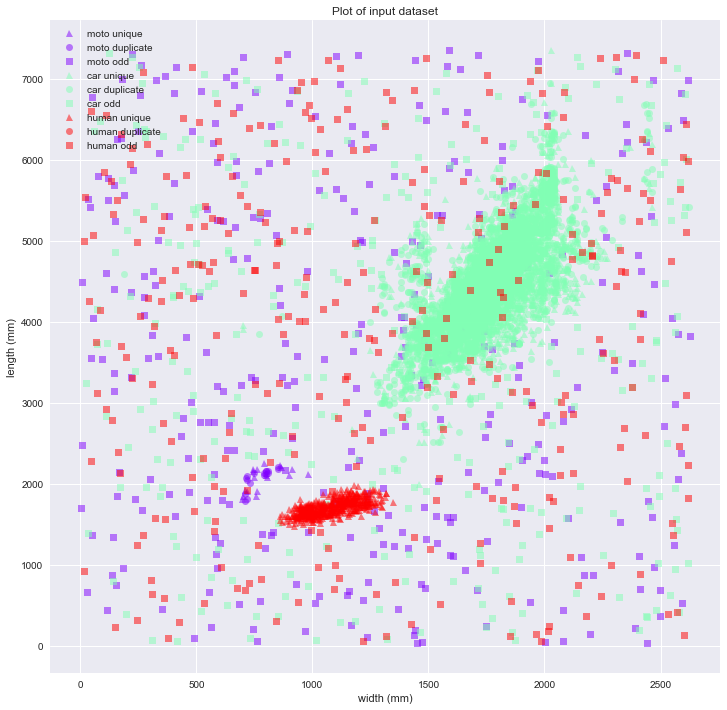

In [6]:
minx, maxx = 0, max(detector.df['width']) + 1
miny, maxy = 0, max(detector.df['length']) + 1
n = 1000
tmp = []
for k in range(n):
    tmp.append([rd.choice(list(set(detector.df['class']))),
                rd.randint(miny, maxy),
                rd.randint(minx, maxx)])
detector.append_odd_points(tmp)
detector.format()
detector.plot()

In the next cells, SVM is missing or commented due to computation time savings. We are still working on the code base. We have not fully explored our possibilities.

Also, classifiers parameters are for now sort of random, the goal here was to make sure the code works. Work in progress.

In [76]:
from sklearn import svm
from sklearn import ensemble
from sklearn import neural_network
from sklearn.tree import DecisionTreeClassifier

classifiers = [
    neural_network.MLPClassifier(hidden_layer_sizes=(30,30,30)),
    ensemble.AdaBoostClassifier(n_estimators=40, learning_rate=0.9),
    # svm.SVC(kernel='linear'),
    ensemble.RandomForestClassifier()
]

titles = (
    'perceptron   ',
    'adaboost     ',
    # 'svm          ',
    'random forest'
)

results = {}
for clf, title in zip(classifiers, titles):
    results[title] = confusion_ratios(detector.classify(clf)[0])

for _ in range(len(titles[0])):
    print(' ', end='')
print('\tTPR\tFPR\tTNR\tFNR')
for title in results.keys():
    print("{0}\t".format(title), end='')
    for x in results[title]:
        print('{0}\t'.format(round(x, 4)), end='')
    print()

             	TPR	FPR	TNR	FNR
perceptron   	0.8155	0.1333	0.8667	0.1845	
adaboost     	0.7149	0.0133	0.9867	0.2851	
random forest	0.8889	0.0068	0.9932	0.1111	


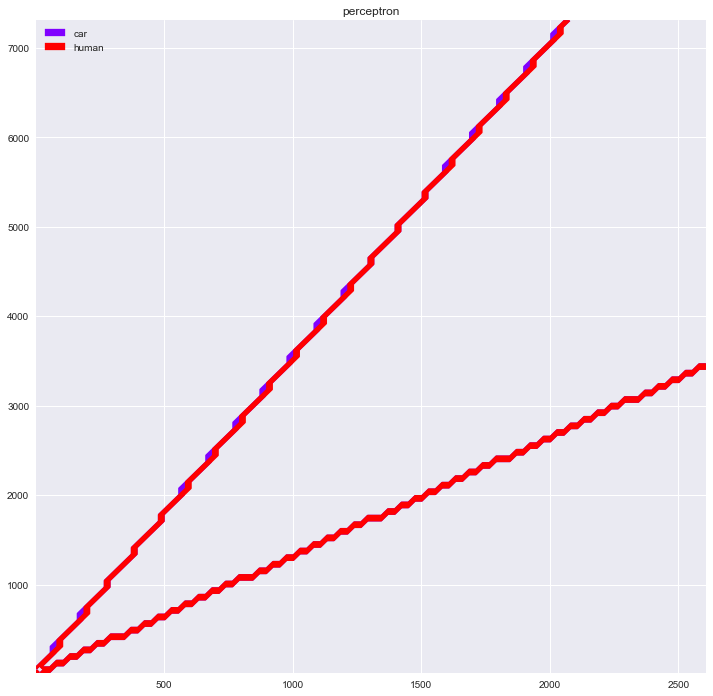

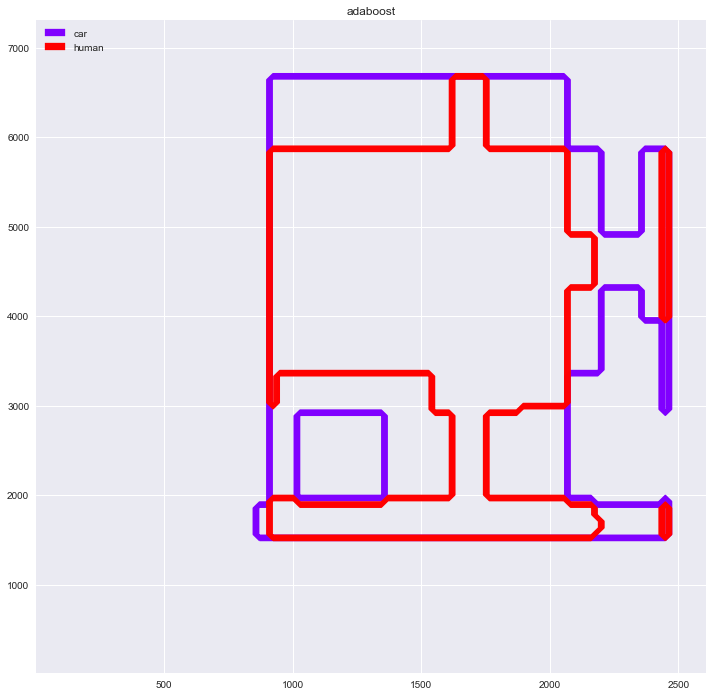

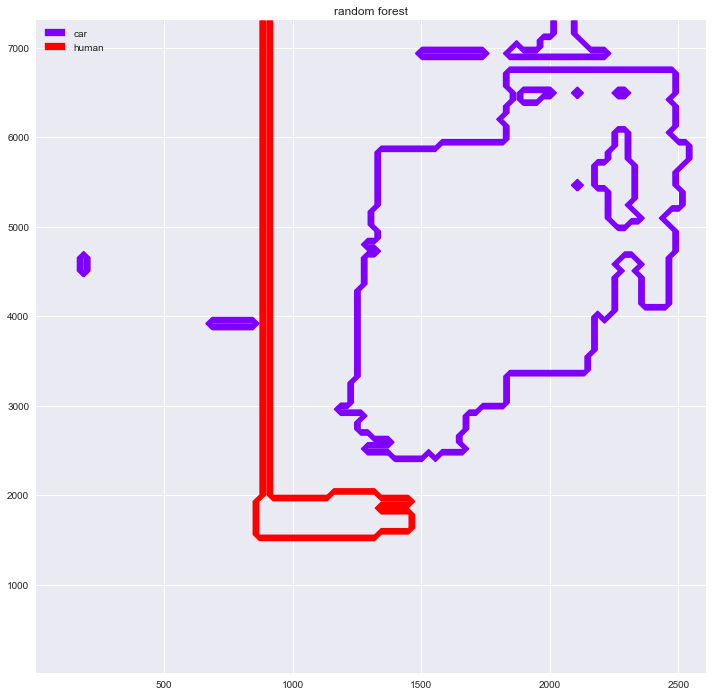

In [71]:
classifiers = [
    neural_network.MLPClassifier(hidden_layer_sizes=(30,30,30)),
    ensemble.AdaBoostClassifier(DecisionTreeClassifier(max_depth=4),n_estimators=36,
                         learning_rate=1),
    ensemble.RandomForestClassifier()
]

titles = (
    'perceptron',
    'adaboost',
    'random forest'
)

for clf, title in zip(classifiers, titles):
    detector.plot_decision_boundaries(clf, title)


In [80]:
score= np.zeros((100,10))
for i in range(1,100):
    for j in [x * 0.1 for x in range(1, 10)]:
        score[i][int(j*10)]=detector.classify(ensemble.AdaBoostClassifier(DecisionTreeClassifier(max_depth=4),n_estimators=i, learning_rate=j))[3]
#test best (n_estimators,learning_rate) comination
a,b= np.unravel_index(np.argmax(score, axis=None),score.shape)
print("Accuracy=" +str(score[a][b])+ "for n_estimators=" + str(a)+"for learning rate="+str((b+1)/10) ) 

Accuracy=0.9806748466257669for n_estimators=36for learning rate=1.0
